## Importings

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D ,MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.applications import VGG19
import matplotlib.pyplot as plt

## Reading data to dataframe

In [2]:
import os
import pandas as pd

folder_path = "/kaggle/input/animal-image-classification-dataset/Animals"

file_paths = []
class_names = []
images = []

for class_name in os.listdir(folder_path):
    class_folder = os.path.join(folder_path, class_name)
    if os.path.isdir(class_folder):  # Ensure it's a folder
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            file_paths.append(file_path)
            class_names.append(class_name)
            # Using CV2
            img = cv2.imread(file_path)
            images.append(img)

df = pd.DataFrame({
    'path': file_paths,
    'class_name': class_names,
    'image': images
})

In [3]:
df.sample(10)

,path,class_name,image
208,/kaggle/input/animal-image-classification-data...,snakes,"[[[32, 65, 91], [13, 46, 72], [12, 46, 70], [2..."
1404,/kaggle/input/animal-image-classification-data...,dogs,"[[[20, 15, 12], [18, 13, 10], [16, 8, 8], [15,..."
1266,/kaggle/input/animal-image-classification-data...,dogs,"[[[148, 156, 155], [148, 156, 155], [149, 157,..."
349,/kaggle/input/animal-image-classification-data...,snakes,"[[[102, 100, 92], [85, 83, 75], [59, 57, 49], ..."
2429,/kaggle/input/animal-image-classification-data...,cats,"[[[173, 176, 190], [174, 177, 191], [175, 178,..."
2263,/kaggle/input/animal-image-classification-data...,cats,"[[[71, 69, 51], [66, 64, 46], [74, 72, 54], [1..."
746,/kaggle/input/animal-image-classification-data...,snakes,"[[[91, 122, 155], [89, 124, 157], [102, 142, 1..."
704,/kaggle/input/animal-image-classification-data...,snakes,"[[[191, 202, 206], [187, 198, 202], [179, 190,..."
2555,/kaggle/input/animal-image-classification-data...,cats,"[[[190, 131, 81], [188, 129, 79], [184, 125, 7..."
585,/kaggle/input/animal-image-classification-data...,snakes,"[[[79, 109, 126], [78, 108, 125], [75, 105, 12..."


### Without Data Augmentation

In [4]:
# X = np.array(df['image'].tolist())

# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(df['class_name'])
# y = np.array(y_encoded)

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Augmentation

In [6]:
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,

)

train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='path',
    y_col='class_name',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='path',
    y_col='class_name',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation')

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


In [7]:
train_size = train_generator.n
validation_size = validation_generator.n

print(f"Training set size (before augmentation): {train_size}")
print(f"Validation set size (before augmentation): {validation_size}")

Training set size (before augmentation): 2400
Validation set size (before augmentation): 600


In [8]:
train_steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps_per_epoch = validation_generator.samples // BATCH_SIZE

print(f"Training steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {validation_steps_per_epoch}")

Training steps per epoch: 75
Validation steps per epoch: 18


## CNN Model Building

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           51

 Total params: 8,788,291 (33.52 MB)

 Trainable params: 8,786,947 (33.52 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [11]:
# change loss to sparse_categorical_entropy if using the labelencoder
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
es = EarlyStopping(monitor='loss', patience=3)

In [13]:
history = model.fit(train_generator, epochs=50, callbacks=[es], validation_data=validation_generator)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745301916.069374     104 service.cc:145] XLA service 0x792cc40087b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745301916.069440     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745301916.069447     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/75 ━━━━━━━━━━━━━━━━━━━━ 28:38 23s/step - accuracy: 0.2188 - loss: 2.3539

I0000 00:00:1745301932.069627     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 534ms/step - accuracy: 0.3768 - loss: 1.9157 - val_accuracy: 0.0000e+00 - val_loss: 5.0379
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 494ms/step - accuracy: 0.4773 - loss: 1.5268 - val_accuracy: 0.0000e+00 - val_loss: 3.9828
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 492ms/step - accuracy: 0.4909 - loss: 1.3972 - val_accuracy: 0.0000e+00 - val_loss: 4.3558
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 485ms/step - accuracy: 0.5303 - loss: 1.2662 - val_accuracy: 0.0000e+00 - val_loss: 4.3786
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 489ms/step - accuracy: 0.5886 - loss: 1.1555 - val_accuracy: 0.0000e+00 - val_loss: 4.4922
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 493ms/step - accuracy: 0.5575 - loss: 1.1400 - val_accuracy: 0.0000e+00 - val_loss: 5.0252
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 489ms/step - accuracy: 0.5712 - loss: 1.1002 - val_accuracy: 0.0133 - val_loss: 4.0066
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 490ms/step - accuracy: 0.5807 - loss: 1.04

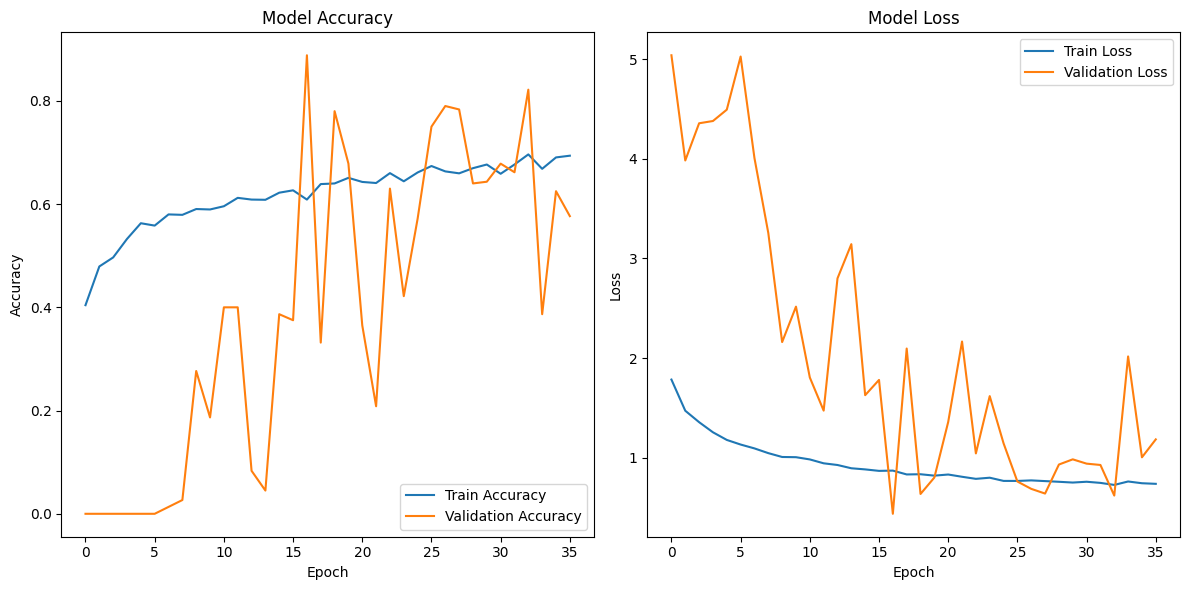

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [15]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False

vgg19 = Sequential()

vgg19.add(base_model)

vgg19.add(Flatten())
vgg19.add(Dense(128, activation='relu'))
vgg19.add(BatchNormalization())
vgg19.add(Dropout(0.5))

vgg19.add(Dense(64, activation='relu'))
vgg19.add(BatchNormalization())
vgg19.add(Dropout(0.3))

vgg19.add(Dense(3, activation='softmax'))

vgg19.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
history = vgg19.fit(train_generator, epochs=50, callbacks=[es], validation_data=validation_generator)

Epoch 1/50


2025-04-22 06:29:43.003483: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-04-22 06:29:43.300597: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.297313132s
Trying algorithm eng12{k11=2} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"oper

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.4955 - loss: 1.2623

2025-04-22 06:30:54.037911: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[24,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-04-22 06:30:55.432900: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.395094832s
Trying algorithm eng12{k11=2} for conv (f32[24,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_qu

75/75 ━━━━━━━━━━━━━━━━━━━━ 93s 803ms/step - accuracy: 0.4965 - loss: 1.2596 - val_accuracy: 0.8750 - val_loss: 0.4059
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 508ms/step - accuracy: 0.6962 - loss: 0.7828 - val_accuracy: 0.9117 - val_loss: 0.2753
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 515ms/step - accuracy: 0.7446 - loss: 0.6985 - val_accuracy: 0.8833 - val_loss: 0.2791
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 516ms/step - accuracy: 0.7774 - loss: 0.5562 - val_accuracy: 0.7833 - val_loss: 0.4689
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 506ms/step - accuracy: 0.7885 - loss: 0.5469 - val_accuracy: 0.8767 - val_loss: 0.2636
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 513ms/step - accuracy: 0.7858 - loss: 0.5588 - val_accuracy: 0.8933 - val_loss: 0.2449
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 516ms/step - accuracy: 0.7869 - loss: 0.5353 - val_accuracy: 0.9217 - val_loss: 0.1772
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 526ms/step - accuracy: 0.8254 - loss: 0.4701 - val_accuracy: 0.923

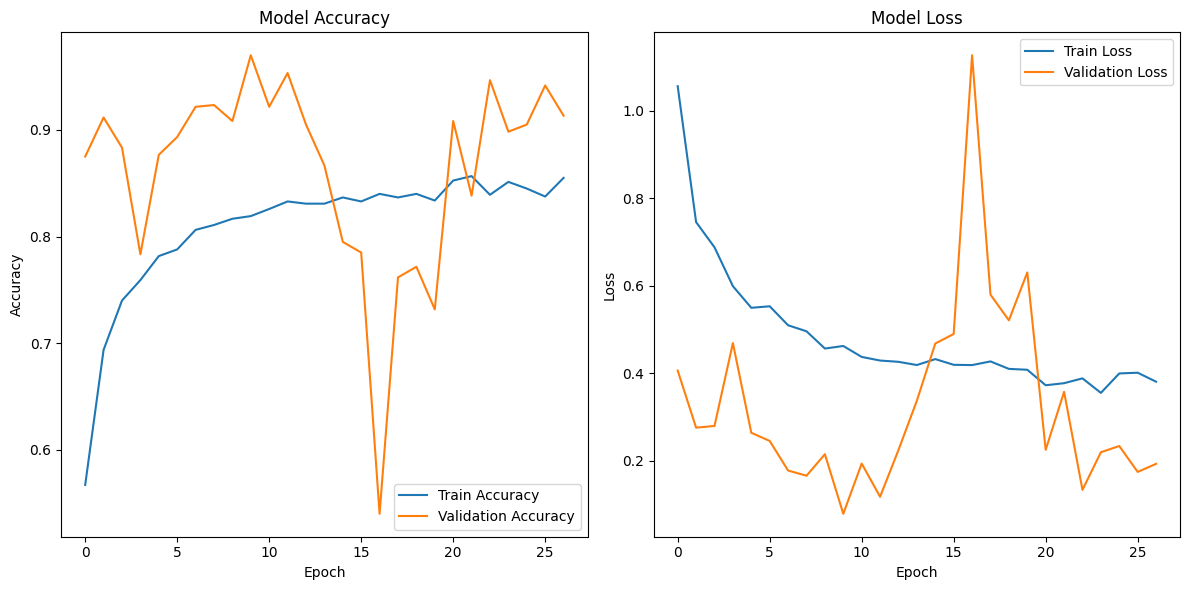

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()